# ScoreStruct

In **maelzel.core** there is a division of concerns between music data (notes, chords, lines, voices, etc) and score structure. The score structure (the `ScoreStruct` class) consists of a set of measure definitions (time signature, tempo). 

* [Defining a score structure](#Defining-a-score-structure)
* [Content / Structure](#Content-/-Structure)
* [Creating a click track from a ScoreStruct](#Creating-a-click-track-from-a-ScoreStruct)
* [Exporting](#Exporting)
* [Musical time vs Real time](#Musical-time-vs-Real-time)


In [1]:
from maelzel.core import *


## Defining a score structure

A `ScoreStruct` can be defined by adding measure definitions or from a string.

Notice at the html representation of the ScoreStruct that there are time signatures which appear between parenthesis: these are inherited time signatures. The same applies to tempo: **if the measure does not define an explicit time signature or tempo, then these attributes are inherited from the previous measure** with an explicit tempo

In [2]:
struct1 = ScoreStruct(r'''
4/4, 4=70
5/8
3/4, 4=140, label="Section B"
3/8
# A first value indicates the measure number. 
# Measures start at 0
10, 4/4, 4=60  
5/16
.      # a period repeats the last measure
7/16
3/8
# Three periods at the end indicate that this score extends indefinitely
...
''')
struct1


Meas. Index,Timesig,Tempo,Label,Rehearsal,Barline,Beats
0,4/4,𝅘𝅥=70,,,,4×𝅘𝅥
1,5/8,,,,,𝅘𝅥+𝅘𝅥𝅭
2,3/4,𝅘𝅥=140,Section B,,,3×𝅘𝅥
3,3/8,,,,,1×𝅘𝅥𝅭
4,(3/8),,,,,1×𝅘𝅥𝅭
5,(3/8),,,,,1×𝅘𝅥𝅭
6,(3/8),,,,,1×𝅘𝅥𝅭
7,(3/8),,,,,1×𝅘𝅥𝅭
8,(3/8),,,,,1×𝅘𝅥𝅭
9,(3/8),,,,,1×𝅘𝅥𝅭


A `ScoreStruct` can be displayed as notation:

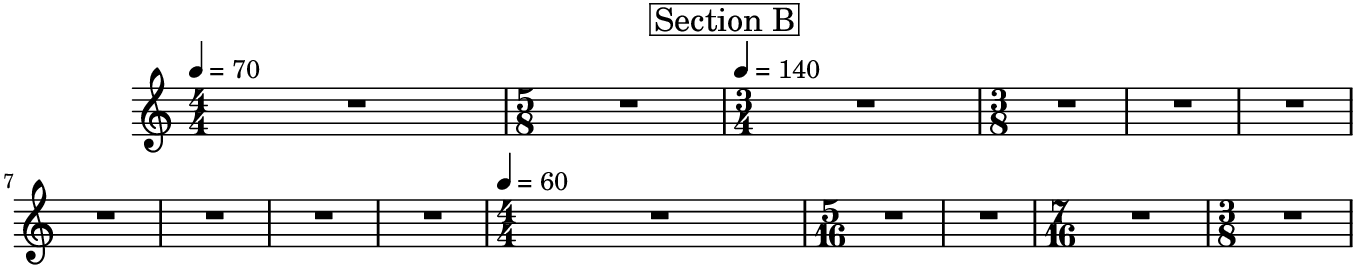

In [4]:
struct1.show()

A `ScoreStruct` can be exported to multiple formats: **musicxml, MIDI, pdf, png, lilypond**. For example, by saving it as MIDI it is possible to import the score structure in a DAW

In [4]:
struct1.write('struct.mid')

This is how the exported MIDI file looks in MuseScore. **NB**: *A note is added to the last measure of the score because an empty score is not imported correctly in many applications*

![](assets/scorestruct-export-midi-musescore.png)

## Content / Structure

As said before, the score structure defines the time signatures and tempi of the measures in a score. The same content can be represented using different score structures. In the example below a score structure is created and used as ad-hoc context. The second call to `.show` is outside the context and the default score structure is used

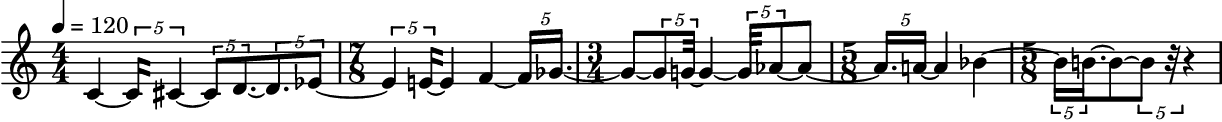

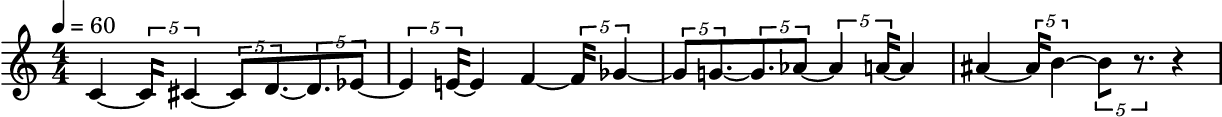

In [5]:
w = getWorkspace()
w.config['quant.complexity'] = 'highest'

struct = ScoreStruct(r'''
4/4, 4=120
7/8
3/4
5/8(2-3)  # It is possible to set the internal subdivisions
5/8(3-2)

...
''')
notes = Chain([Note(m, dur=6/5) for i, m in enumerate(range(60, 72))])

# Used as a context manager, the scorestruct is temporary: the previous
# scorestruct is restored after the context manager exits
with struct:
    notes.show()

notes.show()


## Finding notes

A `Chain` / `Voice` can be queried to locate events at a given time or position in the score. These locations refer to the active scorestruct. In the code below, for example, we search for the event present at the beginning of the 4th measure. 

4A♯:~6/5♩
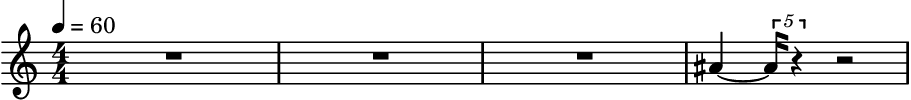

In [6]:
n = notes.eventAt((3, 0))
n

The same but with another scorestruct. Notice that in this case the event found is the active event at the given time but the event itself has a start time prior to the given location.

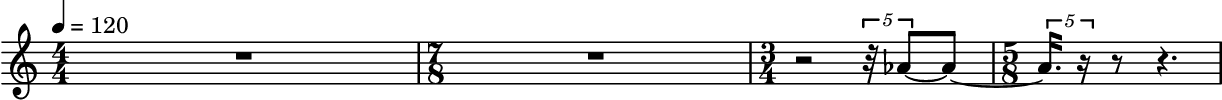

In [8]:
with struct:
    n = notes.eventAt((3, 0))
    n.show()

In order to get the object at precisely the given time, use `split=True`. This will split the returned event at the offset requested, keeping the part tied. This makes it possible to add attributes to the returned part

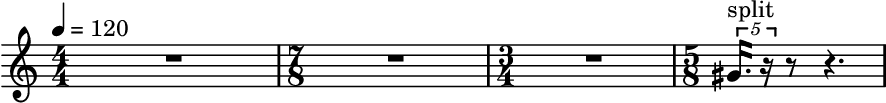

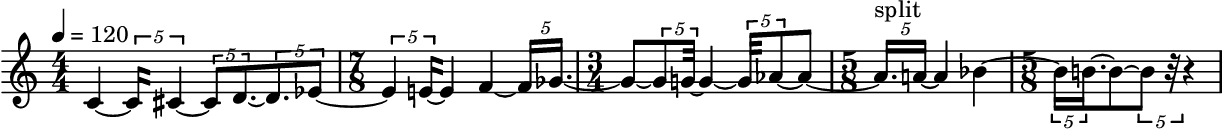

In [9]:
with struct:
    n = notes.eventAt((3, 0), split=True)
    n.addText("split")
    n.show()
    notes.show()

Same content, different score structures. In the next example only the tempo is modified. The resulting notation is the same, because objects in *maelzel.core* define their start time and duration in terms of beats (quarternotes). The playback is modified

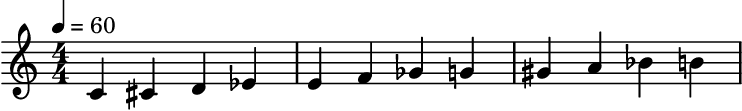

OfflineRenderer(sr=44100)
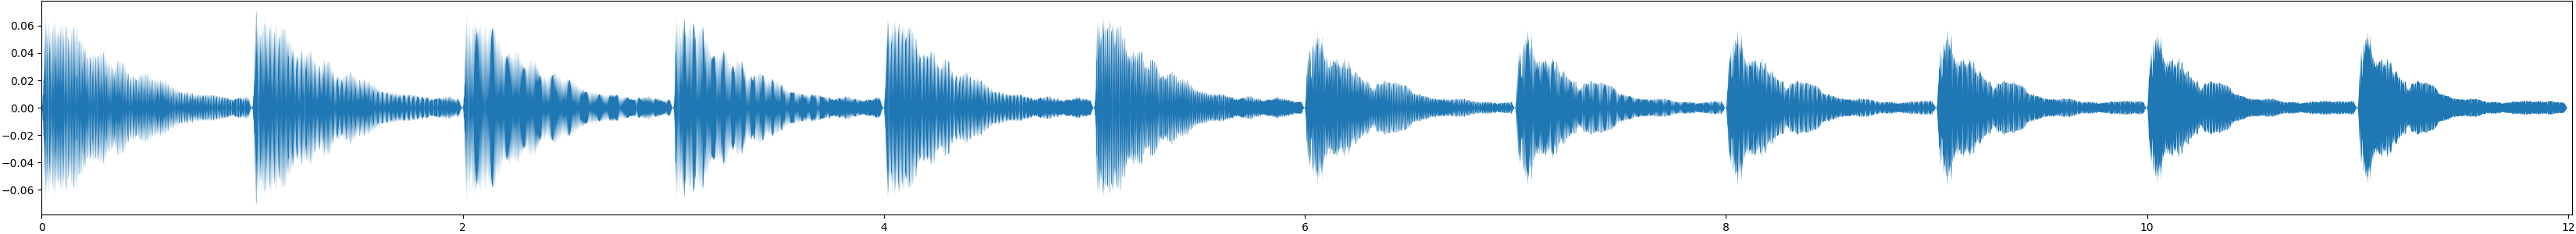

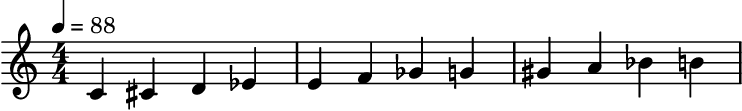

OfflineRenderer(sr=44100)
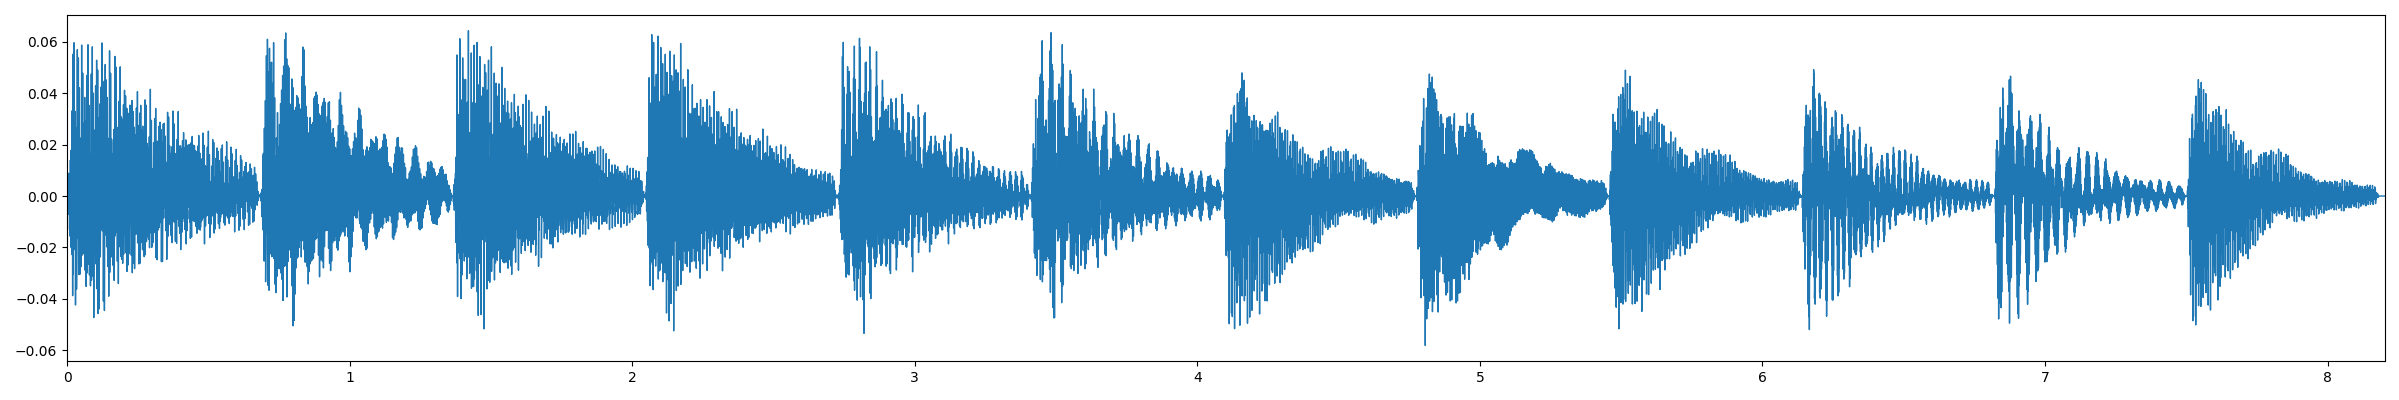

In [4]:
notes2 = Chain([Note(m, dur=F(1, 1)) for i, m in enumerate(range(60, 72))])
notes2.show()
notes2.rec(nchnls=1).show()

with ScoreStruct('4/4', tempo=88):
    notes2.show()
    notes2.rec(nchnls=1).show()


The opposite operation is to fix the events in absolute time (seconds) and make them fit a given scorestruct. This is useful when working with fixed media, where a user might be interested in placing an event at a given moment in absolute time while still being able to use any time signature or tempo. 

**NB**: playback stays unmodified

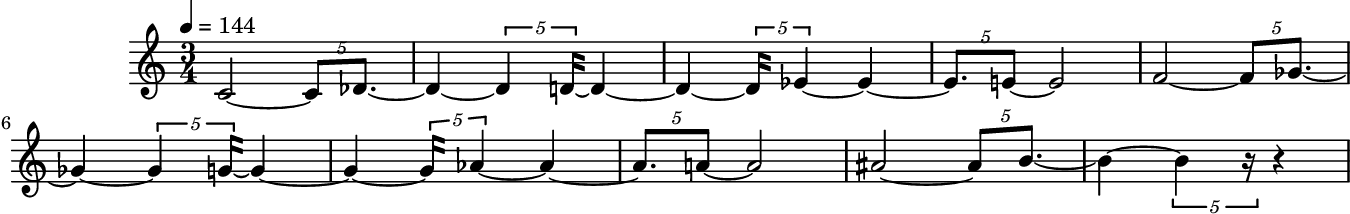

OfflineRenderer(sr=44100)
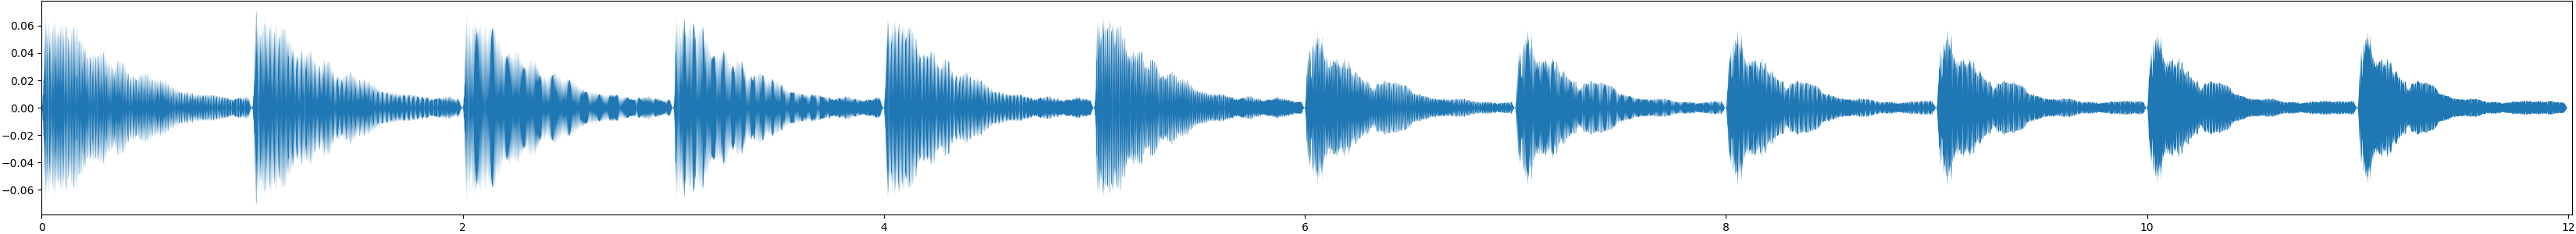

In [5]:
struct3 = ScoreStruct('3/4', tempo=144)
struct = notes2.activeScorestruct()

remappedNotes = []
for n in notes2:
    offset, dur = struct3.remapSpan(struct, n.absOffset(), n.dur)
    remappedNotes.append(n.clone(offset=offset, dur=dur))

chain3 = Chain(remappedNotes)
with struct3:
    chain3.show()
    chain3.rec(nchnls=1).show()

There is a shorthand for this operation: `.remap`. It can be called at the `Chain`/`Voice` level, resulting in all events in chain being remapped to the new score structure:

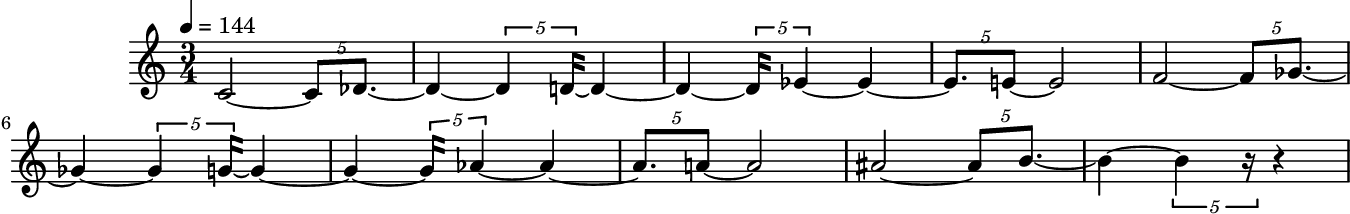

OfflineRenderer(sr=44100)
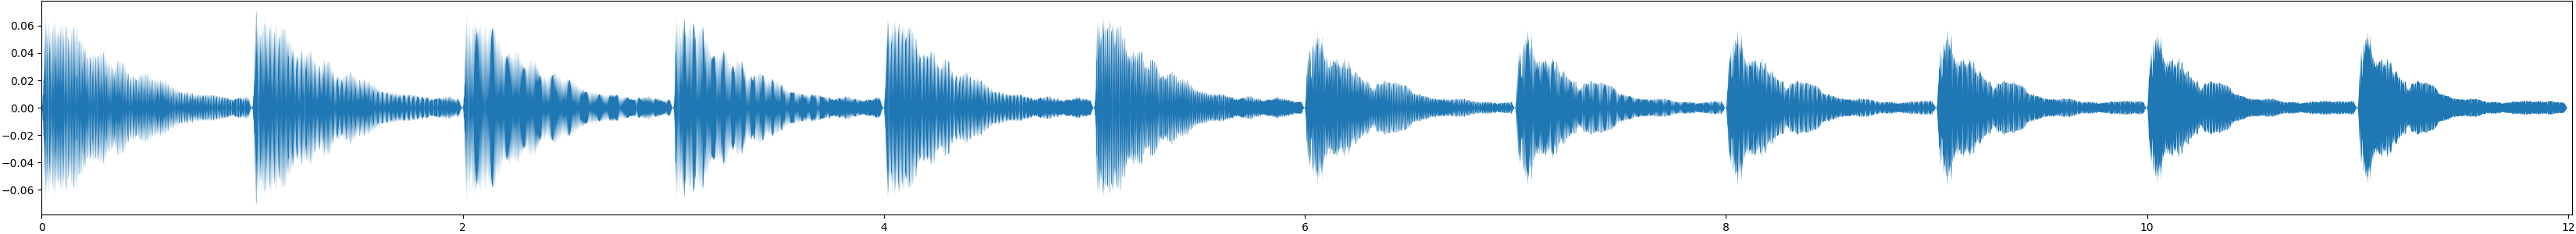

In [7]:
remapped = notes2.remap(struct3)
# The scorestruct is assigned to the new voice
remapped.show()
remapped.rec(nchnls=1)

## The Active ScoreStruct

While working on a specific task it is possible to set active score structure for all operations:


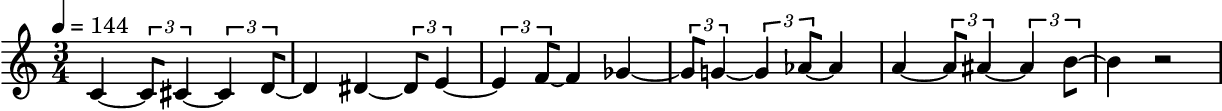

In [6]:
w = getWorkspace()
w.setScoreStruct("3/4, q=144")

seq = Chain([Note(m, dur=F(4, 3)) for i, m in enumerate(range(60, 72))])
seq.show()

## Attaching a ScoreStruct to an object

Instead of relying on the active score, a score structure can be explicitely attached to a `Score` object. 

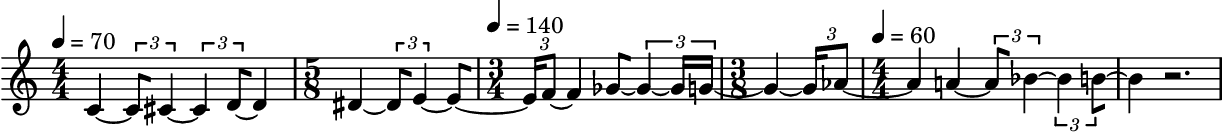

OfflineRenderer(sr=44100)
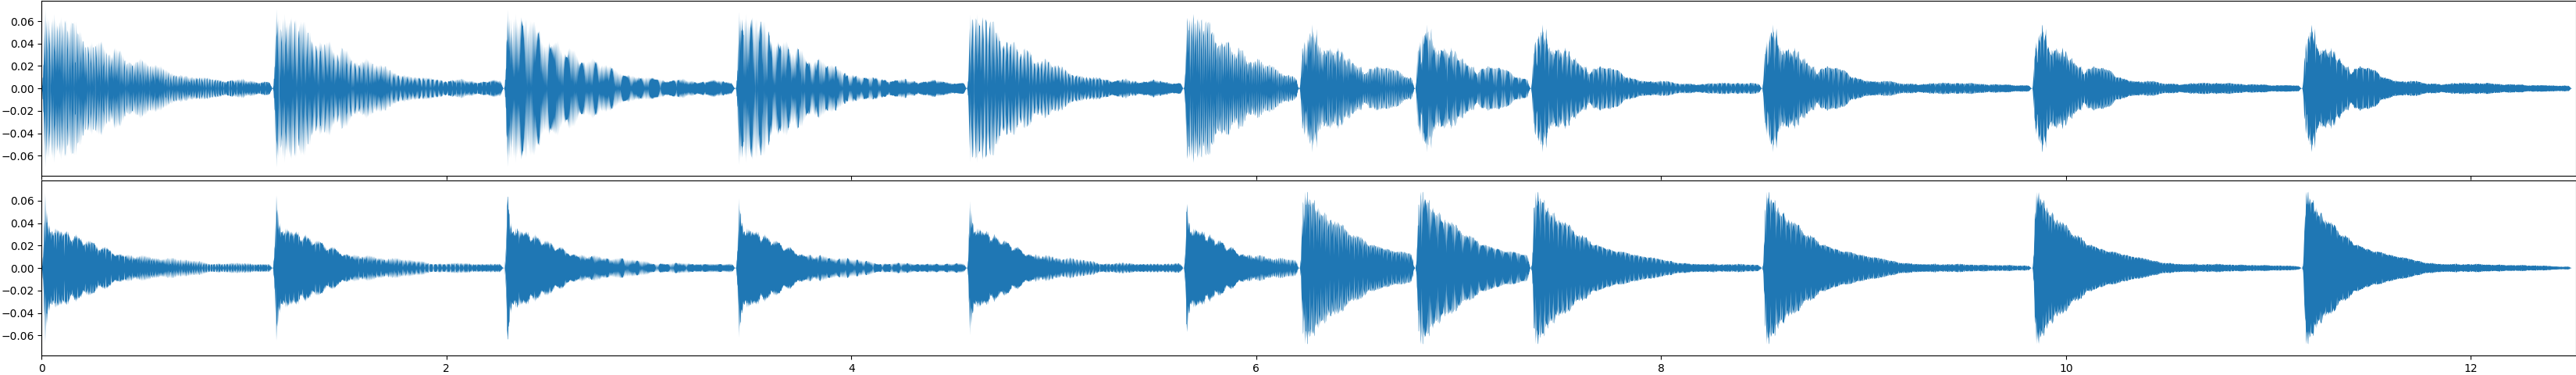

In [12]:
struct1 = ScoreStruct(r'''
4/4, 4=70
5/8
3/4, 4=140
3/8
4/4, 4=60  
...
''')
struct1


sco = Score(voices=[seq], scorestruct=struct1)
sco.show()
sco.rec()

----------------------

## Creating a click track from a ScoreStruct 

It is possible to create a **click track** for any defined ScoreStruct

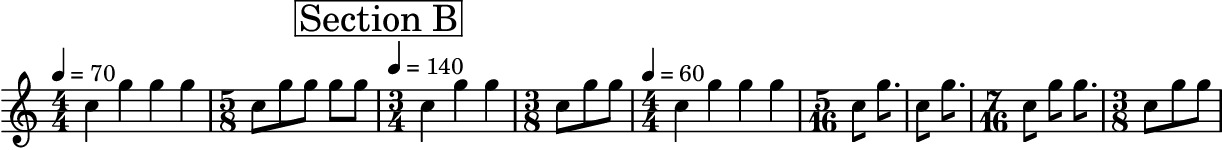

OfflineRenderer(sr=44100)
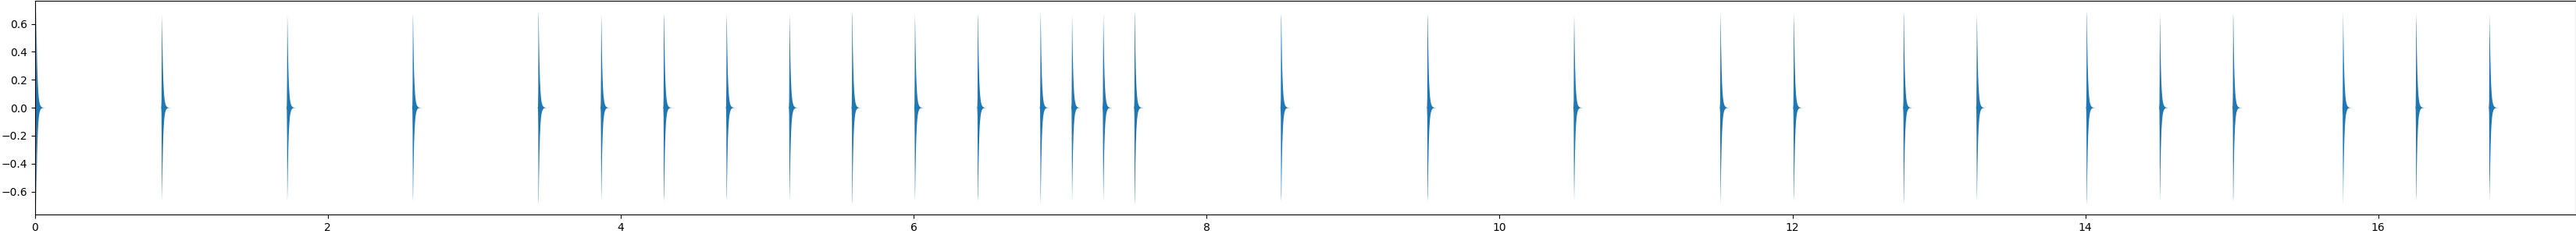

In [14]:
scorestruct = ScoreStruct(r'''
4/4, 70
5/8
3/4, 140, label="Section B"
3/8
4/4, 60
5/16
.
7/16
3/8
...
''')

clicktrack = scorestruct.makeClickTrack()
clicktrack.show()
clicktrack.rec(nchnls=1)


## Exporting

Both the clicktrack and the scorestruct can be exported to many formats: **musicxml**, **MIDI**, **pdf**, **png**, **lilypond**. To export to music21, export first to musicxml and import that into music21

In [17]:
clicktrack.write('clicktrack2.xml')


The clicktrack imported in MuseScore

![](assets/clicktrack2.png)

------

## Sidenote: Musical time vs Real time

To place a musical event at a specific moment in real time (time in seconds, not in quarter notes), use 
the ScoreStruct to convert between both domains.

* **beat**: returns the beat in quarternotes corresponding to the given time in seconds
* **beatDelta**: returns a duration in quarternotes corresponding to the elapsed time between the two given times in seconds

4G:2♩:offset=6
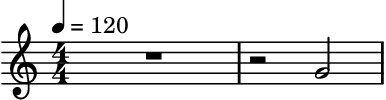

In [22]:
# Create a one second event starting at 3 seconds
s = ScoreStruct(tempo=120).activate()
Note("4G", offset=s.beat(3), dur=s.beatDelta(3, 4))

The same but with another tempo

4G:3/2♩:offset=4.5
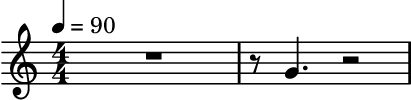

In [23]:
s.setTempo(90)
Note("4G", offset=s.beat(3), dur=s.beatDelta(3, 4))